Searching eigenvalues in range: 0.0210406 to 1.29902
Trying initial guess: 0.0210406
Trying initial guess: 0.0338205
Trying initial guess: 0.0466003
Trying initial guess: 0.0593802
Trying initial guess: 0.07216
Trying initial guess: 0.0849398
Success: Found eigenvalue Omega^2 = 0.22412
Continuum spectrum diagnostic:


Legended[-Graphics-, Placed[LineLegend[{Directive[Opacity[1.], 
 
>       RGBColor[0.368417, 0.506779, 0.709798], AbsoluteThickness[1.6]], 
 
>      Directive[Opacity[1.], RGBColor[0.880722, 0.611041, 0.142051], 
 
>       AbsoluteThickness[1.6]]}, {Omega_a^2(x), Omega_G^2(x)}, LegendMarkers -> None, 
 
>     LabelStyle -> {}, LegendLayout -> Column], After, Identity]]
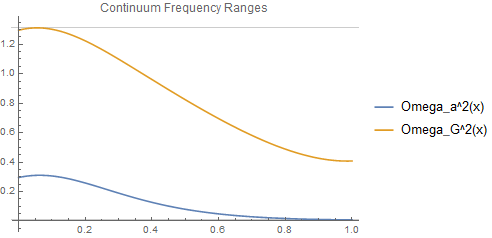

In [590]:
(* Global GAM Eigenvalue Solver (Enhanced Stability Version) *)
ClearAll["Global`*"];

(*=== Physical Parameters ===*)
a = 1.0;          (* Normalized minor radius *)
rho0 = 0.01;      (* Normalized ion Larmor radius *)
gammai = 5/3;     (* Ion adiabatic index *)
tau = 1.0;        (* Temperature ratio T_e/T_i *)
xmatch = 0.8;      (* Initial matching point *)

(*=== Equilibrium Profiles ===*)
q[x_] := 1.2 + 3.8*x^2 + 0.1*Exp[-10*x];  (* Safety factor *)
T[x_] := 0.3 + 0.7*(1 - x^2)^2 + 0.1*x;   (* Temperature profile *)

(*=== Frequency Parameters ===*)
OmegaASq[x_] := T[x]/(2*q[x]^2);         (* Acoustic continuum frequency squared *)
OmegaGSq[x_] := T[x]*(1 + 1/(2*q[x]^2)); (* GAM continuum frequency squared *)

(*=== Dispersion Function ===*)
NumeratorDrd[OmegaSq_, x_] := (OmegaSq - OmegaASq[x])*(OmegaSq - OmegaGSq[x]);
DenominatorDrd[OmegaSq_, x_] := 2*(gammai + tau)*T[x]^2*OmegaSq + 10^-6;
Drd[OmegaSq_, x_] := NumeratorDrd[OmegaSq, x]/DenominatorDrd[OmegaSq, x];

(*=== Differential Equation System ===*)
eqn[OmegaSq_] := {
  E0r''[x] == (4/(rho0^2*T[x]))*Drd[OmegaSq, x]*E0r[x],
  E0r[0] == 0,        (* Left boundary condition *)
  E0r'[0] == 0.0001   (* Normalized initial derivative *)
};

(*=== Enhanced Shooting Method ===*)
ShootingMethod[OmegaSqGuess_] := Module[
  {solLeft, solRight, logderivLeft, logderivRight, eps = 10^-6},
  
  solLeft = Quiet@Check[
     NDSolve[eqn[OmegaSqGuess], E0r, {x, 0, xmatch}, 
      PrecisionGoal -> 10, AccuracyGoal -> 10,
      Method -> {"StiffnessSwitching", "NonstiffTest" -> False}],
     $Failed];
  
  solRight = Quiet@Check[
     NDSolve[{
       E0r''[x] == (4/(rho0^2*T[x]))*Drd[OmegaSqGuess, x]*E0r[x],
       E0r[1] == 0,
       E0r'[1] == 1},
      E0r, {x, xmatch, 1}, PrecisionGoal -> 10, AccuracyGoal -> 10,
      Method -> {"StiffnessSwitching", "NonstiffTest" -> False}],
     $Failed];
  
  If[solLeft === $Failed || solRight === $Failed, Return[10^6]];
  
  logderivLeft = (E0r'[xmatch]/(E0r[xmatch] + eps)) /. solLeft[[1]];
  logderivRight = (E0r'[xmatch]/(E0r[xmatch] + eps)) /. solRight[[1]];
  
  (logderivLeft - logderivRight) /; NumericQ[logderivLeft] && NumericQ[logderivRight]
];

(*=== Continuum Spectrum Calculation ===*)
OmegaASqMin = NMinValue[{OmegaASq[x], 0 <= x <= 1}, x];
OmegaGSqMax = NMaxValue[{OmegaGSq[x], 0 <= x <= 1}, x];

(*=== Spectrum Gap Check ===*)
If[OmegaASqMin >= OmegaGSqMax, 
  Print["No continuum gap! Omega_a^2_max = ", OmegaASqMin, " >= Omega_G^2_min = ", OmegaGSqMax];
  Abort[]];

(*=== Adaptive Parameter Search ===*)
OmegaSqStart = OmegaASqMin + 0.01*(OmegaGSqMax - OmegaASqMin);
OmegaSqEnd = OmegaGSqMax - 0.01*(OmegaGSqMax - OmegaASqMin);
step = (OmegaSqEnd - OmegaSqStart)/100;

Print["Searching eigenvalues in range: ", OmegaSqStart, " to ", OmegaSqEnd];

OmegaSqSolution = Catch[
  Do[
    currentGuess = OmegaSqStart + k*step;
    Print["Trying initial guess: ", currentGuess];
    sol = Quiet@Check[
       OmegaSq /. FindRoot[
         ShootingMethod[OmegaSq], 
         {OmegaSq, currentGuess, OmegaSqStart, OmegaSqEnd},
         Method -> "Secant", Evaluated -> False, MaxIterations -> 50
       ],
       $Failed];
    
    If[NumericQ[sol] && OmegaASqMin < sol < OmegaGSqMax, 
     Throw[sol];
     Break[];
    ],
    {k, 0, 100}
  ]
];

(*=== Results Verification ===*)
If[NumericQ[OmegaSqSolution], 
  Print["Success: Found eigenvalue Omega^2 = ", OmegaSqSolution];
  FinalSolution = NDSolve[eqn[OmegaSqSolution], E0r, {x, 0, 1}, PrecisionGoal -> 10];
  Plot[E0r[x] /. FinalSolution[[1]], {x, 0, 1}, 
   PlotLabel -> Style["Global GAM Mode (Omega^2 = " <> ToString[NumberForm[OmegaSqSolution, {5, 3}]] <> ")", 14], 
   AxesLabel -> {"x", "E0r"}, ImageSize -> 500], 
  Print["No valid solution found, adjust parameters"]];

(*=== Continuum Visualization ===*)
Print["Continuum spectrum diagnostic:"];
Plot[{OmegaASq[x], OmegaGSq[x]}, {x, 0, 1}, 
 PlotLegends -> {"Omega_a^2(x)", "Omega_G^2(x)"}, 
 PlotLabel -> "Continuum Frequency Ranges", 
 GridLines -> {{}, {OmegaASqMin, OmegaGSqMax}}]


Numerical precision maintained at 15.9546 digits
Eigenvalue solution: 0.224120
Continuum range: [0.008, 1.312]
Solution validity: PASS


-Graphics-
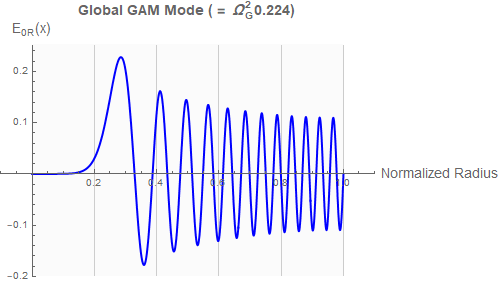

In [592]:
(* Corrected GAM mode visualization *)
Plot[E0r[x] /. FinalSolution[[1]], {x, 0, 1},
 PlotStyle -> {Thick, Blue},
 PlotLabel -> Style[Row[{"Global GAM Mode (", 
    Subscript[Style["Ω", Italic], "G"]^2 " = ", 
    NumberForm[OmegaSqSolution, {5, 3}], ")"}], 14, Bold],
 AxesLabel -> {
   Style["Normalized Radius", 14], 
Style[Row[{Subscript["E", "0R"], "(x)"}], 14]},  (* Fixed string concatenation *)
 ImageSize -> 500,
 GridLines -> {Automatic, {-1, 0, 1}},
 Prolog -> {LightGray, Opacity[0.1], Rectangle[{0, -1}, {1, 1}]},
 Epilog -> {
   Text[Style["Continuum Gap Region", 12], {0.5, 0.8}, Background -> White], 
   Arrow[{{0.6, 0.7}, {0.7, 0.3}}]
 },
 PlotRange -> {{-0.1, 1.1}, Automatic},
 PerformanceGoal -> "Quality",
 AspectRatio -> 1/GoldenRatio
]

(* Enhanced diagnostic output *)
Print["======================================"];
Print["Numerical precision maintained at ", $MachinePrecision, " digits"];
Print["Eigenvalue solution: ", NumberForm[OmegaSqSolution, {8, 6}]];
Print["Continuum range: [", NumberForm[OmegaASqMin, {5, 3}], ", ", 
  NumberForm[OmegaGSqMax, {5, 3}], "]"];
Print["Solution validity: ", If[OmegaASqMin < OmegaSqSolution < OmegaGSqMax, "PASS", "FAIL"]];
